In [1]:
import pandas as pd
import numpy as np

In [2]:
from litreading.grade import DataGrader, grade_wcpm
from litreading.train import ModelTrainer
from litreading.config import SEED

## 1. Open Data as pandas dataframe

In [3]:
df = pd.read_csv("./data/larger_wcpm.csv")
df.head()

,human_wcpm,human_transcript,asr_transcript,prompt,scored_duration
0,107,every night at bedtime ben told stories to his...,bigfoot every night at bedtime ben told storie...,every night at bedtime ben told stories to his...,60.0
1,128,once upon a time there was an elephant who liv...,once upon a time there was an elephant who liv...,once upon a time there was an elephant who liv...,60.0
2,88,today's the big day said ruth what big day ask...,today's the big day said ruth what big day ask...,today's the big day said ruth what big day ask...,60.0
3,109,once upon a time there was an elephant who liv...,once upon a time there was an elephant who liv...,once upon a time there was an elephant who liv...,60.0
4,127,last summer my daddy went wait no last summer ...,last summer my daddy went to last summer my da...,last summer my daddy sent me to the store for ...,60.0


## 2. Predict grades based on already trained models

### 2.1 With function

In [4]:
grades = grade_wcpm(df.loc[:50])
grades.head()

2020-10-25 12:11:30,013 root         INFO     Loading model from ./litreading/models/XGB.joblib


,human_wcpm,human_transcript,asr_transcript,prompt,scored_duration,wcpm_estimation
0,107,every night at bedtime ben told stories to his...,bigfoot every night at bedtime ben told storie...,every night at bedtime ben told stories to his...,60.0,100.0
1,128,once upon a time there was an elephant who liv...,once upon a time there was an elephant who liv...,once upon a time there was an elephant who liv...,60.0,126.1
2,88,today's the big day said ruth what big day ask...,today's the big day said ruth what big day ask...,today's the big day said ruth what big day ask...,60.0,89.8
3,109,once upon a time there was an elephant who liv...,once upon a time there was an elephant who liv...,once upon a time there was an elephant who liv...,60.0,111.7
4,127,last summer my daddy went wait no last summer ...,last summer my daddy went to last summer my da...,last summer my daddy sent me to the store for ...,60.0,126.7


### 2.2 Instanciate DataGrader

In [5]:
grader = DataGrader(df.loc[:50],  # mandatory
                    model_type='XGB',  # optional, default XGB
                    prompt_col='prompt',  # optional, default 'prompt'
                    asr_col='asr_transcript',  # optional, default 'asr_transcript'
                    duration_col='scored_duration',  # optional, default 'scored_duration'
                   )


2020-10-25 12:11:30,175 root         INFO     Loading model from ./litreading/models/XGB.joblib


#### Option 1: use grade_wcpm method
Same as using grade_wcpm function, but you have access to the DataGrader instance after if you want to modify something

In [6]:
grades = grader.grade_wcpm(only_wcpm=False)  # optional, default False. If True, returns only the wcpm estimation
grades[['prompt', 'asr_transcript', 'human_wcpm', 'wcpm_estimation']].head()

,prompt,asr_transcript,human_wcpm,wcpm_estimation
0,every night at bedtime ben told stories to his...,bigfoot every night at bedtime ben told storie...,107,100.0
1,once upon a time there was an elephant who liv...,once upon a time there was an elephant who liv...,128,126.1
2,today's the big day said ruth what big day ask...,today's the big day said ruth what big day ask...,88,89.8
3,once upon a time there was an elephant who liv...,once upon a time there was an elephant who liv...,109,111.7
4,last summer my daddy sent me to the store for ...,last summer my daddy went to last summer my da...,127,126.7


#### Option 2: step-by-step grading to choose different options such as preprocessing steps

Default preprocessing steps are specified in the `config.py` file. Hence they will be used by default for both prediction and training if need be.

In [7]:
grader.preprocess_data(lowercase=True,  # optional, default True
                       punctuation_free=True,  # optional, default True
                       convert_num2words=True,  # optional, default True
                       asr_string_recomposition=False,  # optional, default False
                       inplace=True  # optional, default False
                      )

grader.compute_features(inplace=True)  # optional, default False
grades = grader.estimate_wcpm(inplace=False) # optional, default False 

Retrieve only the grades:

In [8]:
grades.head()

0    100.0
1    126.1
2     89.8
3    111.7
4    126.7
Name: wcpm_estimation, dtype: float64

Retrieve the whole dataframe:

In [9]:
grader.get_data().head()

,human_wcpm,human_transcript,asr_transcript,prompt,scored_duration,wcpm_estimation
0,107,every night at bedtime ben told stories to his...,bigfoot every night at bedtime ben told storie...,every night at bedtime ben told stories to his...,60.0,100.0
1,128,once upon a time there was an elephant who liv...,once upon a time there was an elephant who liv...,once upon a time there was an elephant who liv...,60.0,126.1
2,88,today's the big day said ruth what big day ask...,today's the big day said ruth what big day ask...,today's the big day said ruth what big day ask...,60.0,89.8
3,109,once upon a time there was an elephant who liv...,once upon a time there was an elephant who liv...,once upon a time there was an elephant who liv...,60.0,111.7
4,127,last summer my daddy went wait no last summer ...,last summer my daddy went to last summer my da...,last summer my daddy sent me to the store for ...,60.0,126.7


## 3. Train a model

### 3.1 Train a model with default params

#### 3.1.a Instanciate
Instanciate ModelTrainer and preprocess the data. You have to choose several parameters that are all listed here. You have to choose between Random Forest ('RF'), XGBoost('XGB') and K nearest neighbors ('KNN'). You will be able to change it after without re processing the data using the set_new_model(model_type, params) method.

In [10]:
config = {
    'model_type': 'XGB',  # available: 'Baseline', 'RF', 'KNN', 'XGB'
    'remove_outliers': True,
    'outliers_tol': .15,  # default is .2
    'test_set_size': .2,
    'seed': SEED
}

# Instanciate the trainer
trainer = ModelTrainer(df,  # mandatory
                       model_type = config['model_type']  # optional, default 'XGB'
                      )

2020-10-25 12:11:30,564 root         INFO     New model set: XGB


#### 3.1.b Training and test sets and feature computation
Prepare the training and test sets. You have the choice to remove outliers or not. Here, outliers are defined as data points where the number of words in th asr transcript and the human transcript defer by more than `outliers_tol` in percentage. 

e.g.: 100 words in asr transcript, 115 in human transcript: absolute difference of 15%. The datapoint will be removed with `outliers_tol=.1`, kept with `outliers_tol=.2`

In [11]:
trainer.prepare_train_test_set(remove_outliers=config['remove_outliers'],  # optional, default False
                               outliers_tol=config['outliers_tol'],  # optional, default .2, used if remove_outliers=True,
                               test_set_size=config['test_set_size'],  # optional, default .2
                               inplace=True  # optional, default True
                              )

2020-10-25 12:11:37,344 root         INFO     Removed 166 outliers, 2876 datapoints remaining for training/testing


Take a look at the features used to estimate the wcpm (after standard scaling), plus label 'human_wc':

In [12]:
trainer.features.describe()

,correct_words_pm,added_words_pm,removed_words_pm,replaced_words_pm,asr_word_count_pm,prompt_avg_word_length,prompt_std_word_length,asr_avg_word_length,asr_std_word_length,human_wcpm
count,2876.000000,2876.000000,2876.000000,2876.000000,2876.000000,2876.000000,2876.000000,2876.000000,2876.000000,2876.000000
mean,107.682377,9.626946,11.225832,3.795793,117.619406,4.217915,1.969704,4.129150,1.882962,109.109875
std,36.296089,6.614929,24.599078,3.765989,36.515448,0.513844,0.369361,0.536421,0.359985,37.148994
min,0.000000,0.000000,0.000000,0.000000,0.803732,2.357000,0.667000,2.000000,0.000000,0.000000
25%,85.000000,5.000000,2.000000,1.000000,95.582619,4.040000,1.855000,3.914750,1.691750,86.000000
50%,112.000000,8.302016,4.553308,3.000000,122.000000,4.258000,1.993000,4.179000,1.935000,113.000000
75%,133.000000,13.000000,10.000000,5.000000,142.000000,4.523000,2.229000,4.440000,2.114250,134.250000
max,219.591194,78.000000,284.654213,41.000000,253.000000,5.207000,2.757000,5.429000,2.985000,259.000000


#### 3.1.c Training
Default parameters for all models are scikit-learn default params. If you want to use you own hyperparameters, please use `trainer.set_params(your_own_params_dict)`.
We tuned hyperparameters based on data we had and they are stored for all models in the `config.py` file. If you want to use them, please use `trainer.set_params('config_params')`

In [13]:
print(trainer.get_model_params())
trainer.set_model_params('config_params')
print(trainer.get_model_params())

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'gamma': None, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': None, 'max_delta_step': None, 'max_depth': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 105, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.9, 'gamma': 5, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.02, 'max_delta_step': None, 'max_depth': 7, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimato

In [14]:
trainer.train()

2020-10-25 12:11:37,449 root         INFO     Training XGB


#### 3.1.d Evaluate the model
Evaluate the model by getting 3 dataframes:
- stats with all statistics for all datapoints
- summary with statistics like MAE, MAE%, RMSE divided in 3 bins of data per human_wcpm value: -75 words, 75-150, 150+
- errors with count and % or errors > 1%, 5%, 10% for the 3 bins of data.

You can specify `visualize=True` if you want to have a graph of error distribution. An alternative it to call later `grader.plot_wcpm_distribution()`.

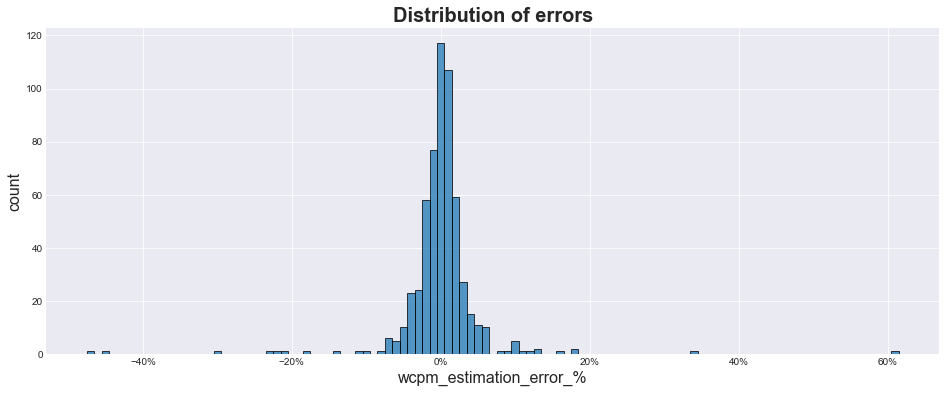

In [15]:
stats, summary, errors = trainer.evaluate_model(visualize=True)  # default is True for visualize

In [16]:
stats.head()

,wcpm_estimation,human_wcpm,wcpm_estimation_error,wcpm_estimation_abs_error,wcpm_estimation_error_%,wcpm_estimation_abs_error_%,RMSE,wcpm_bin,Total Count,Error > 1%,Error > 5%,Error > 10%
24,127.014389,128,0.985611,0.985611,0.007700,0.007700,0.971429,75-150,True,False,False,False
2337,129.550827,130,0.449173,0.449173,0.003455,0.003455,0.201756,75-150,True,False,False,False
1528,140.973969,143,2.026031,2.026031,0.014168,0.014168,4.104804,75-150,True,True,False,False
222,53.145142,54,0.854858,0.854858,0.015831,0.015831,0.730783,<75,True,True,False,False
50,117.806686,117,-0.806686,0.806686,-0.006895,0.006895,0.650743,75-150,True,False,False,False


In [17]:
summary

wcpm_estimation_error       wcpm_estimation_abs_error        \
                          mean   std                      mean   std   
wcpm_bin                                                               
150+                      2.37  7.46                      4.04  6.69   
75-150                   -0.03  2.85                      1.94  2.09   
<75                       0.26  4.62                      2.49  3.89   
total                     0.30  4.04                      2.28  3.35   

         wcpm_estimation_abs_error_%         RMSE          
                                mean   std   mean     std  
wcpm_bin                                                   
150+                            2.25  3.06  60.39  267.34  
75-150                          1.75  1.90   8.12   27.91  
<75                             5.96  9.91  21.22  111.85  
total                           2.57  4.87  16.38  104.96

In [18]:
errors

Total Count          Error > 1%          Error > 5%           \
               count % of bin      count % of bin      count % of bin   
wcpm_bin                                                                
150+            65.0    100.0       36.0     55.4        9.0     13.8   
75-150         407.0    100.0      233.0     57.2       19.0      4.7   
<75            104.0    100.0       86.0     82.7       31.0     29.8   
total          576.0    100.0      355.0     61.6       59.0     10.2   

         Error > 10%           
               count % of bin  
wcpm_bin                       
150+             2.0      3.1  
75-150           3.0      0.7  
<75             16.0     15.4  
total           21.0      3.6

You can also visualize feature importance for Random Forests and boosting models. This method will raise an error if applied to a ModelTrainer instance currently using a BaselineModel or KNN model.

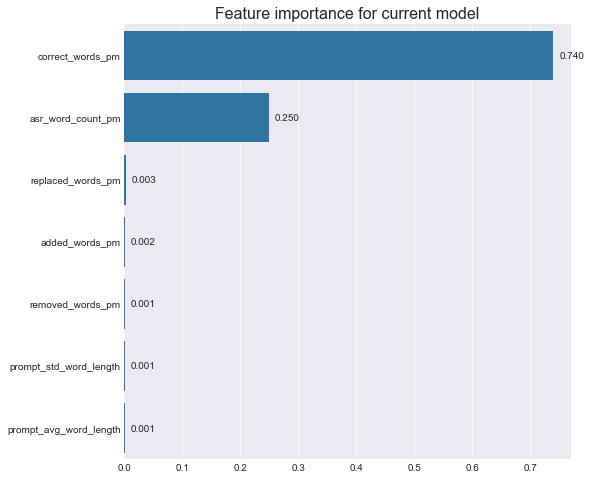

In [19]:
trainer.feature_importance()

#### 3.1.e Saving models

You can save models using the `trainer.save_models()` methods. You can choose what you want to save (scaler and / or model) and if you want to replace previous models or not (this will delete previous models of te same type). The saving directory is `MODELS_PATH` from `config.py`.

In [20]:
trainer.save_model(scaler = False,  # default is False
                  model = True,  # default is False
                  replace = False  # default is False
                 )

2020-10-25 12:11:41,732 root         INFO     Saved file XGB_0.joblib in dir ./litreading/models/


### 3.2 Train a model and tune hyperparameters using grid search

Now we want to train another model and decide with what parameters. You can do so without having to redo the preprocesssing: we can use self.set_new_model() and specify both the model type and the params for the model. 

#### 3.2.a Specify model and parameters and train

Here are the parameters of the default models already trained for the package. Thay were finetuned using sklearn gridsearch, with the functions detailed below. If you want to retrain the model with same parameters, please use `trainer.set_params('config_params)`.

In [21]:
# We will use RF here, but you can use any of the models and params listed below
# model_type = 'XGB'
# params = {'n_estimators': 800,
#           'learning_rate': 0.02,
#           'max_depth': 7,
#           'subsample': 0.8,
#           'colsample_bytree': 0.9,
#           'gamma': 5
#          }

# model_type = 'KNN'
# params = {'n_neighbors': 4,
#           'weights': 'distance'
#          }

model_type = 'RF'
params = {'max_features': 6,
          'n_estimators': 600,
          'max_depth': 10,
          'min_samples_split': 4,
          'min_samples_leaf': 1,
          'bootstrap': True
         }

# model_type = 'Baseline'
# params = {}

trainer.set_new_model(model_type=model_type,
                      params=params,
                      inplace=True
                     )

# As they are the params defined in config.py, we can also do:
# trainer.set_new_model(model_type=model_type,
#                       params='config_params',
#                       inplace=True
#                      )

2020-10-25 12:11:41,750 root         INFO     New model set: RF


In [22]:
trainer.train()
stats, summary, errors = trainer.evaluate_model(visualize=False)
summary

2020-10-25 12:11:41,764 root         INFO     Training RF


wcpm_estimation_error       wcpm_estimation_abs_error        \
                          mean   std                      mean   std   
wcpm_bin                                                               
150+                      2.83  9.19                      4.63  8.42   
75-150                   -0.03  2.78                      1.99  1.95   
<75                      -0.19  4.31                      2.65  3.40   
total                     0.26  4.37                      2.40  3.65   

         wcpm_estimation_abs_error_%          RMSE          
                                mean    std   mean     std  
wcpm_bin                                                    
150+                            2.54   3.79  91.20  435.67  
75-150                          1.80   1.78   7.73   21.66  
<75                             6.79  11.32  18.47   73.02  
total                           2.78   5.51  19.09  151.96

#### 3.2.b Visualization 
An alternative to `visualize=True` in `trainer.evaluate_model()` is to use `trainer.plot_wcpm_distribution`:

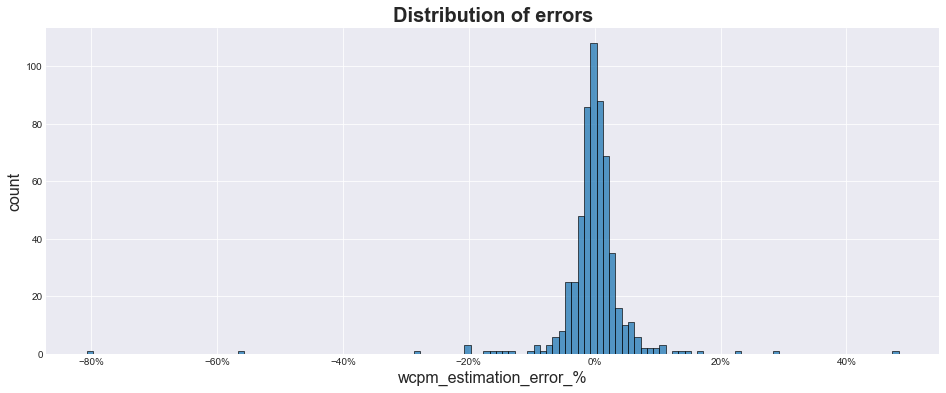

In [23]:
trainer.plot_wcpm_distribution(stats=stats,  # mandatory
                               x='wcpm_estimation_error_%',  # optional, default is 'wcpm_estimation_error_%'
                               stat='count',  # optional, default is 'count'
                               binwidth=.01, # optional, default is '.01'
                              )

You can also print a scatter plot of errors and wcpm estimatiosn to see where are the biggest errors and what is the performance of the model:

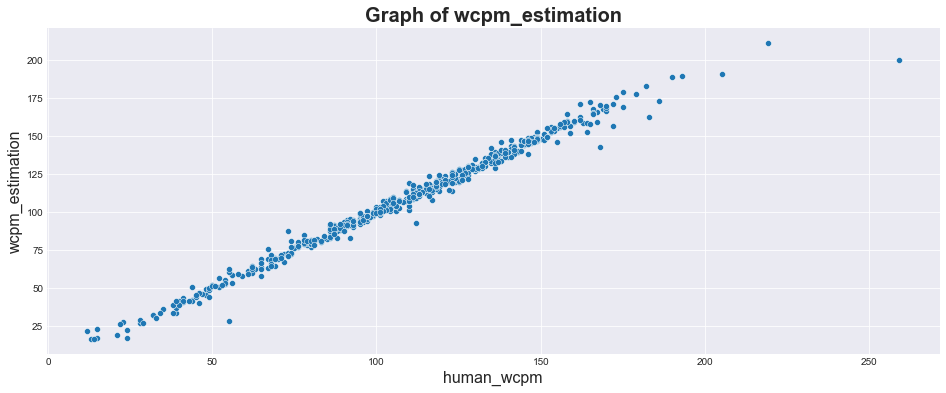

In [24]:
trainer.plot_wcpm_scatter(stats,  # mandatory
                          y = 'wcpm_estimation',  # optional, default 'wcpm_estimation_error_%'
                          x = 'human_wcpm'  # optional, default 'human_wcpm'
                         )

#### 3.2.c training the Baseline model

The Baseline model is implemeneted as a basic longest common subsequence using the Difflib package. The class BaselineModel is defined in `utils.py`.

2020-10-25 12:11:47,287 root         INFO     New model set: Baseline
2020-10-25 12:11:47,289 root         INFO     Training Baseline


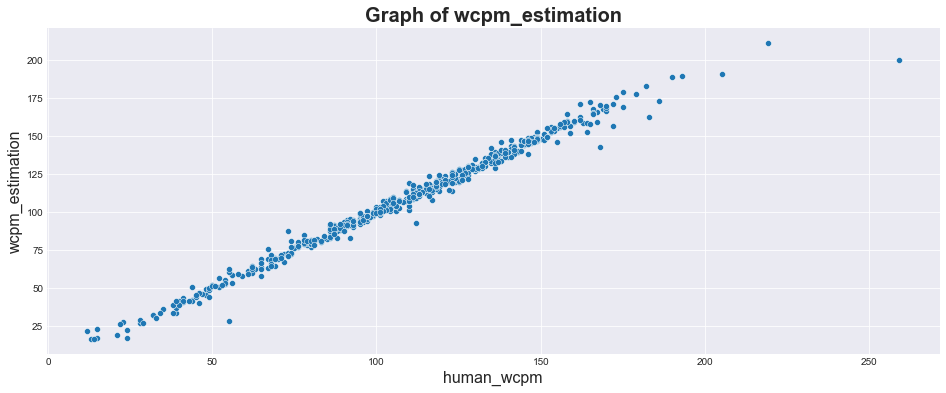

In [25]:
trainer.set_new_model(model_type = 'Baseline')
trainer.train()
trainer.plot_wcpm_scatter(stats, y = 'wcpm_estimation', x = 'human_wcpm')

## 4. Grid search

### 4.1 set parameters and model

In [26]:
# RandomForestRegressor
model_type = 'RF'
cv_params={
    'max_features': np.arange(1, 9, 1),
#     'n_estimators': list(np.arange(100, 2001, 100)),
#     'max_depth': np.arange(1, 20, 1)
#     'min_samples_split': np.arange(1, 15, 1),
#     'min_samples_leaf': np.arange(1, 6, 1)
#     'bootstrap': [True, False]
}

### 4.2 Train and validate models

Grid earch is available only for model_type in `['RF', 'KNN', 'XGB']`.

In [27]:
gd = trainer.grid_search(model_type = model_type,
                         cv_params=cv_params,
                         cv_folds=5,
                         scoring_metric = 'r2',
                         verbose = 5
                        )


------------------------------------------------------ Estimator: ------------------------------------------------------
RandomForestRegressor

------------------------------------------------ Metric for evaluation: ------------------------------------------------
r2

------------------------------------------------- Params to be tested: -------------------------------------------------
max_features [1 2 3 4 5 6 7 8]

 # of possible combinations to be cross-validated: 8

Continue with these c-v parameters ? (y/n)  y
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   17.8s finished


### 4.3 Visualize results

{'max_features': 7}


2020-10-25 12:12:10,312 matplotlib.legend WARNING  No handles with labels found to put in legend.


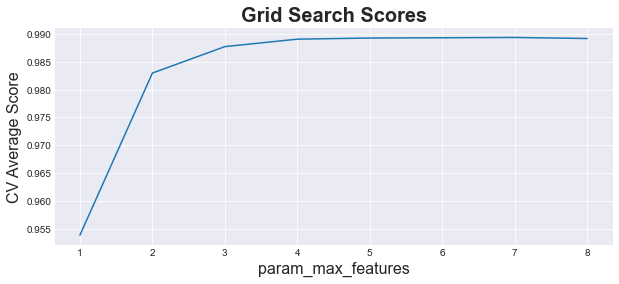

In [28]:
print(gd.best_params_)
trainer.plot_grid_search(gd.cv_results_, x='max_features', hue=None, log_scale = False)

### 4.4 Select and save model

In [29]:
trainer.save_model(scaler=True, model=True, replace=False)

2020-10-25 12:12:10,441 root         INFO     Saved file standard_scaler_0.joblib in dir ./litreading/models/
2020-10-25 12:12:10,675 root         INFO     Saved file RF_0.joblib in dir ./litreading/models/
